In [5]:
#BiocManager::install("MMUPHin")
#BiocManager::install("UniprotR")
library(MMUPHin)
library(Maaslin2)
library(UniprotR)
library(magrittr)
library(dplyr)
library(limma)
library(edgeR)
library(knitr)
library(ggplot2)
library(vegan)
library(pheatmap)
library(tidyr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2


Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract




In [2]:
genefamilies <- read.delim("merged_cpm_genefamilies_crc.tsv")

In [3]:
#Tots els valors han de ser enters                                          
genefamilies[1:nrow(genefamilies),2:length(genefamilies)] <- as.data.frame(lapply(genefamilies[1:nrow(genefamilies),
                                                                       2:length(genefamilies)], as.integer))
#Modifiquem nom columnes
tmp <- strsplit(readLines("merged_cpm_genefamilies_crc.tsv", n=1), "\t")[[1]]
nms <- tmp[2:length(tmp)]
names(genefamilies)[2:length(genefamilies)] <- gsub("_Abundance-RPKs", "", nms)
                                          
#Modifiquem nom files
row.names(genefamilies) <- genefamilies[1:nrow(genefamilies),1]
genefamilies <- genefamilies[,2:length(genefamilies)]

#Eliminem fila UNMAPPED
genefamilies <- genefamilies[2:nrow(genefamilies), 1:length(genefamilies)]

#Eliminem files amb 0 per totes les mostres
genefamilies <- genefamilies[rowSums(genefamilies > 0)>0,1:length(genefamilies)]

In [4]:
metadata <- read.csv("metadades_full.csv")
# afegim variable study (Batch)
metadata$study <- substr(metadata$sample,1,6)
# convertim condition a factor
metadata$condition <- factor(metadata$condition, levels=c("Control", "CRC"))
metadata$region <- factor(metadata$region, levels=c("Xina", "EUA"))
metadata$seq_tool[which(metadata$seq_tool=="NaN")] <- "Altre"
metadata$seq_tool <- factor(metadata$seq_tool, levels=c("NovaSeq", "HiSeq", "Altre"))
# reordenem per alinear mostres amb les columnes del arxiu de counts
metadata$sample2 <- metadata$sample
metadata <- left_join(data.frame(sample2 = colnames(genefamilies)), metadata)
#canviem nom de files
rownames(metadata) <- metadata$sample
#eliminem columnes no necessàries
metadata <- metadata[1:nrow(metadata),3:length(metadata)]

Joining, by = "sample2"


In [5]:
#Transformem counts a taula no estratificada
unstrat_table <- function(counts) {
    temp = counts[!grepl("\\|", rownames(counts)),]
    return(temp)
}
genefamilies_unstrat <- unstrat_table(genefamilies)

In [123]:
Xina_samples <- row.names(metadata)[metadata$region=="Xina"]
EUA_samples <- row.names(metadata)[metadata$region=="EUA"]
genefamilies_unstrat_Xina <- genefamilies_unstrat[,Xina_samples]
genefamilies_unstrat_EUA <- genefamilies_unstrat[,EUA_samples]
metadata_Xina <- metadata[Xina_samples,]
metadata_EUA <- metadata[EUA_samples,]

In [125]:
fit_adjust_batch <- MMUPHin::adjust_batch(feature_abd=genefamilies_unstrat_Xina, batch="study",
                                covariates = c("condition"),
                                data = metadata_Xina,
                                control = list(verbose=TRUE))
genefamilies_unstrat_adj_Xina <- fit_adjust_batch$feature_abd_adj
write.table(genefamilies_unstrat_adj_Xina, file = "genefamilies_adj_Xina.tsv", sep="\t", row.names=FALSE)

feature_abd is counts

Warning message in check_batch(df_batch[[batch]], min_n_batch = 2):
“Batch variable is not a factor as provided and will be converted to one.”
Found 4 batches

Adjusting for 1 covariate(s) or covariate(s) level(s)

Pseudo count is not specified and set to half of minimal non-zero value: 5e-01

Adjusting for (after filtering) 123589 features

Standardizing data across features

Estimating batch difference parameters and EB priors

Performing shrinkage adjustments on batch difference parameters

Performing batch corrections



In [127]:
fit_adjust_batch <- MMUPHin::adjust_batch(feature_abd=genefamilies_unstrat_EUA, batch="study",
                                covariates = c("condition"),
                                data = metadata_EUA,
                                control = list(verbose=TRUE))
genefamilies_unstrat_adj_EUA <- fit_adjust_batch$feature_abd_adj
write.table(genefamilies_unstrat_adj_EUA, file = "genefamilies_adj_EUA.tsv", sep="\t", row.names=FALSE)

feature_abd is counts

Warning message in check_batch(df_batch[[batch]], min_n_batch = 2):
“Batch variable is not a factor as provided and will be converted to one.”
Found 2 batches

Adjusting for 1 covariate(s) or covariate(s) level(s)

Pseudo count is not specified and set to half of minimal non-zero value: 5e-01

Adjusting for (after filtering) 16516 features

Standardizing data across features

Estimating batch difference parameters and EB priors

Performing shrinkage adjustments on batch difference parameters

Performing batch corrections



In [128]:
maaslin <- Maaslin2(input_data = genefamilies_unstrat_adj_Xina,
                    input_metadata = metadata_Xina,
                    output = "maaslin2_genefamilies_Xina",
                    fixed_effects = c("condition"),
                    random_effects = c("study"),
                    normalization = "NONE",
                    min_abundance = 0.0001,
                    min_prevalence = 0.1,
                    plot_scatter = FALSE,
                     cores = 7)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[1] "There is not enough metadata in the associations to create a heatmap plot. Please review the associations in text output file."


In [295]:
set.seed(42)
CRC_Xina_samples <- sample(row.names(metadata)[metadata$condition=="CRC" & metadata$region=="Xina"],28)
C_Xina_samples <- sample(row.names(metadata)[metadata$condition=="Control" & metadata$region=="Xina"],28)

In [313]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")

In [314]:
#0.01
nrow(toptable[toptable$qval < 0.01,])
#0.00001
nrow(toptable[toptable$qval < 0.00001,])
#0.000001
nrow(toptable[toptable$qval < 0.000001,])
#0.0000005
nrow(toptable[toptable$qval < 0.0000005,])
#0.0000001
nrow(toptable[toptable$qval < 0.0000001,])
#0.00000005
nrow(toptable[toptable$qval < 0.00000005,])
#0.00000001
nrow(toptable[toptable$qval < 0.00000001,])

[1] 11125

[1] 217

[1] 54

[1] 35

[1] 16

[1] 8

[1] 5

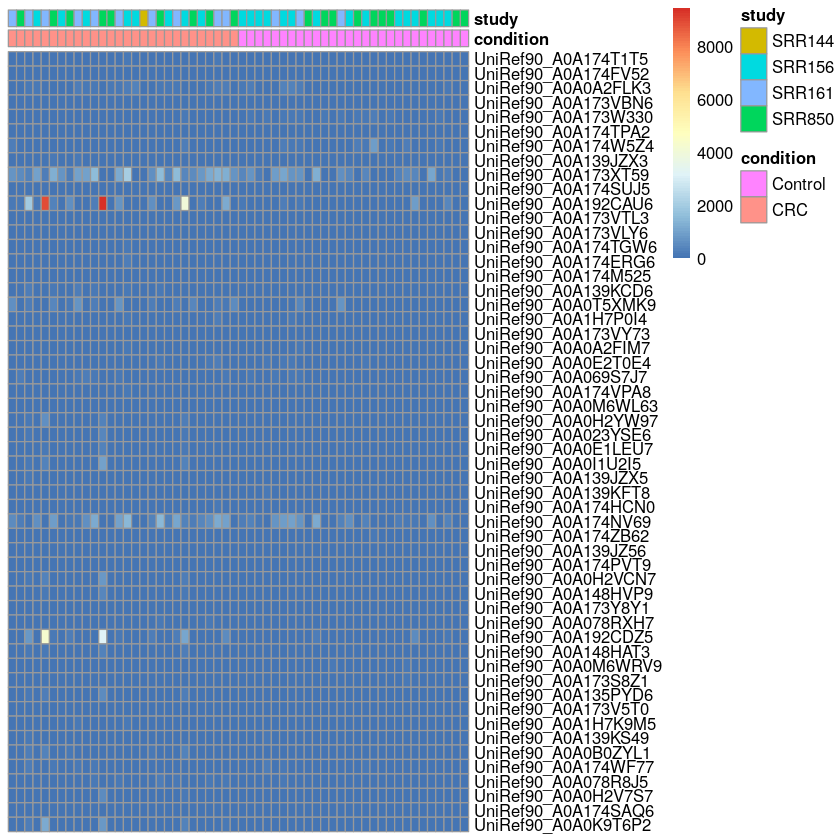

In [315]:
topgenes <- toptable[(toptable$qval < 0.000001),] #SIGNATURE 54
mat  <- genefamilies_unstrat_adj_Xina[topgenes$feature, c(CRC_Xina_samples, C_Xina_samples)]  
pheatmap(mat, cluster_rows=FALSE, cluster_cols=FALSE, annotation_col = metadata_Xina[,c(3,4)], show_colnames = FALSE)

In [323]:
set.seed(42)
CRC_SRR156_samples <- sample(row.names(metadata)[metadata$condition=="CRC" & metadata$study=="SRR156"],28)
C_SRR156_samples <- sample(row.names(metadata)[metadata$condition=="Control" & metadata$study=="SRR156"],28)
CRC_SRR161_samples <- sample(row.names(metadata)[metadata$condition=="CRC" & metadata$study=="SRR161"],28)
C_SRR161_samples <- sample(row.names(metadata)[metadata$condition=="Control" & metadata$study=="SRR161"],28)
CRC_SRR850_samples <- sample(row.names(metadata)[metadata$condition=="CRC" & metadata$study=="SRR850"],28)
C_SRR850_samples <- sample(row.names(metadata)[metadata$condition=="Control" & metadata$study=="SRR850"],28)

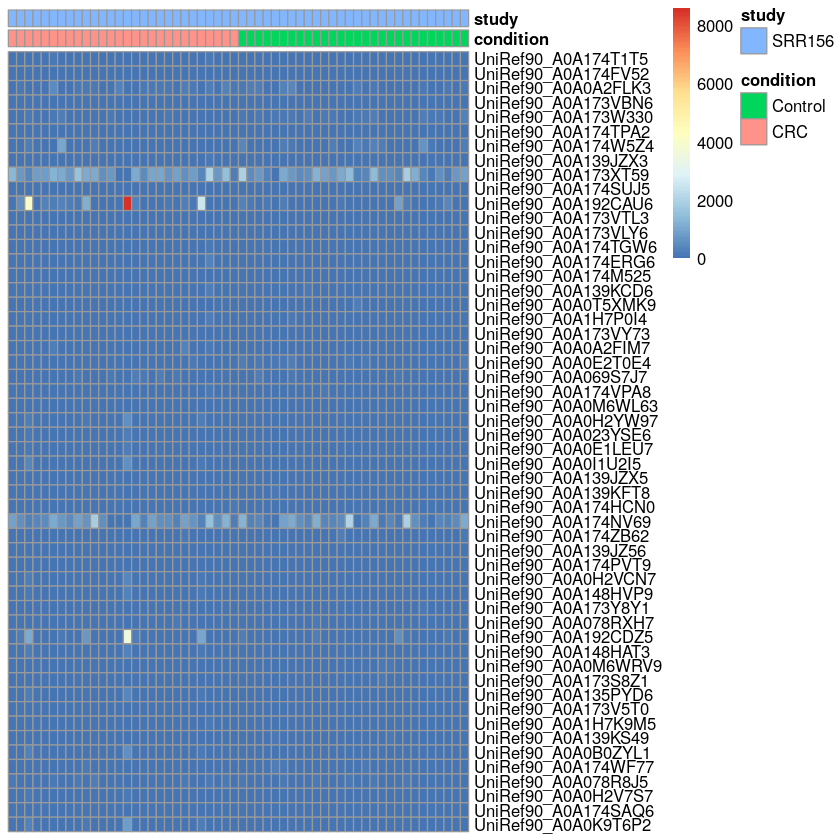

In [328]:
topgenes <- toptable[(toptable$qval < 0.000001),] #SIGNATURE 54
mat  <- genefamilies_unstrat_adj_Xina[topgenes$feature, c(CRC_SRR156_samples, C_SRR156_samples)]  
pheatmap(mat, cluster_rows=FALSE, cluster_cols=FALSE, annotation_col = metadata_Xina[,c(3,4)], show_colnames = FALSE)

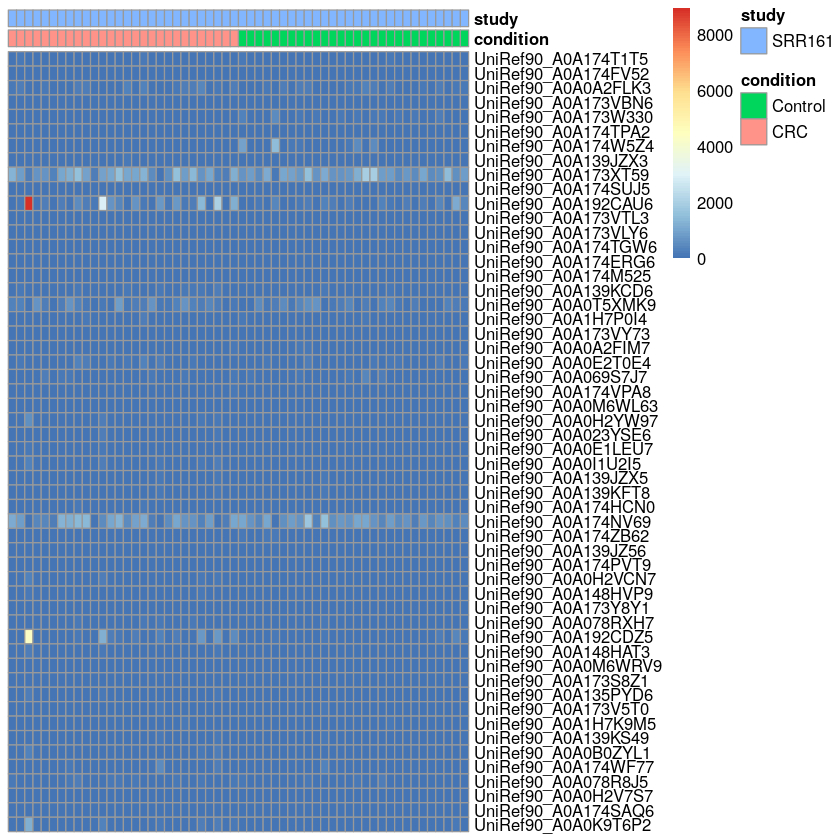

In [331]:
topgenes <- toptable[(toptable$qval < 0.000001),] #SIGNATURE 54
mat  <- genefamilies_unstrat_adj_Xina[topgenes$feature, c(CRC_SRR161_samples, C_SRR161_samples)]  
pheatmap(mat, cluster_rows=FALSE, cluster_cols=FALSE, annotation_col = metadata_Xina[,c(3,4)], show_colnames = FALSE)

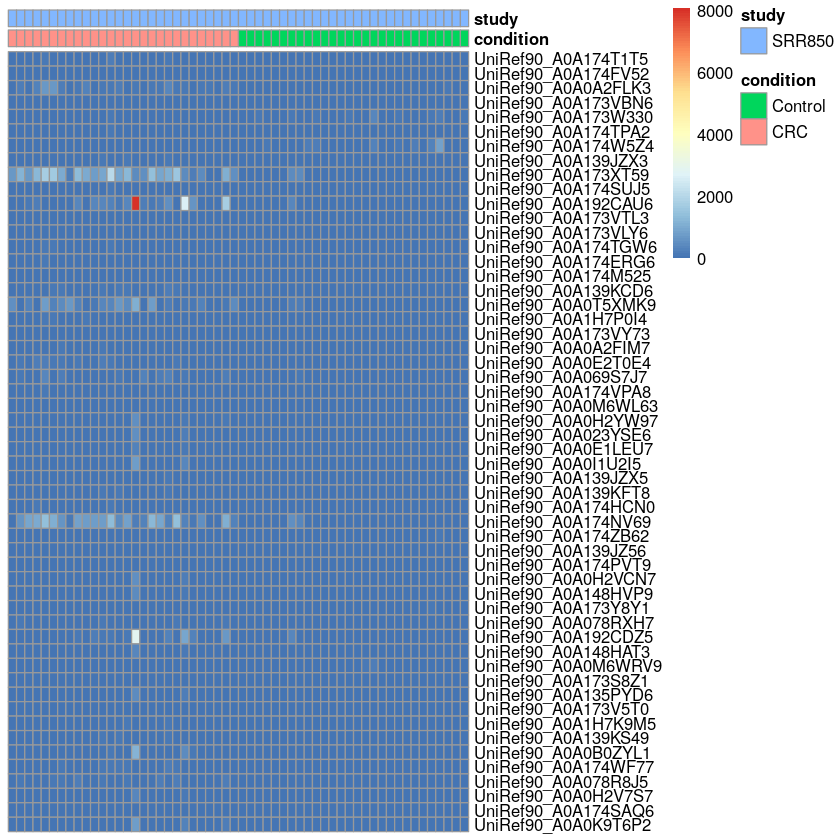

In [332]:
topgenes <- toptable[(toptable$qval < 0.000001),] #SIGNATURE 54
mat  <- genefamilies_unstrat_adj_Xina[topgenes$feature, c(CRC_SRR850_samples, C_SRR850_samples)]  
pheatmap(mat, cluster_rows=FALSE, cluster_cols=FALSE, annotation_col = metadata_Xina[,c(3,4)], show_colnames = FALSE)

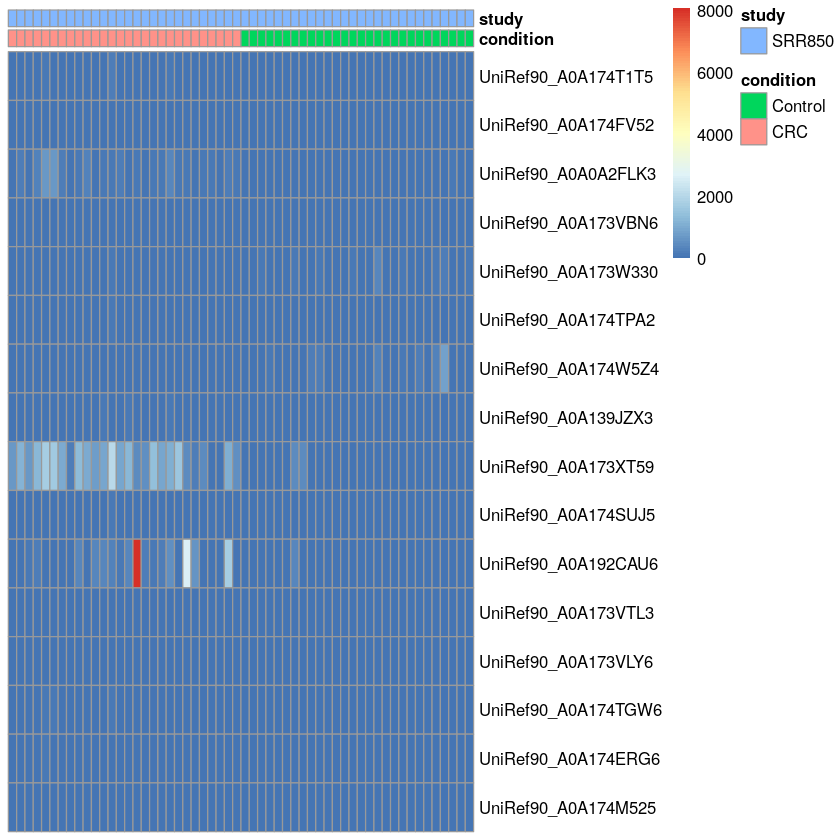

In [334]:
topgenes <- toptable[(toptable$qval < 0.0000001),] #SIGNATURE 16
mat  <- genefamilies_unstrat_adj_Xina[topgenes$feature, c(CRC_SRR850_samples, C_SRR850_samples)]  
pheatmap(mat, cluster_rows=FALSE, cluster_cols=FALSE, annotation_col = metadata_Xina[,c(3,4)], show_colnames = FALSE)

In [179]:
maaslin <- Maaslin2(input_data = genefamilies_unstrat_adj_EUA,
                    input_metadata = metadata_EUA,
                    output = "maaslin2_genefamilies_EUA",
                    fixed_effects = c("condition"),
                    random_effects = c("study"),
                    normalization = "NONE",
                    min_abundance = 0.0001,
                    min_prevalence = 0.1,
                    plot_scatter = FALSE,
                     cores = 7)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[1] "There is not enough metadata in the associations to create a heatmap plot. Please review the associations in text output file."


In [303]:
set.seed(42)
CRC_EUA_samples <- sample(row.names(metadata)[metadata$condition=="CRC" & metadata$region=="EUA"],28)
C_EUA_samples <- sample(row.names(metadata)[metadata$condition=="Control" & metadata$region=="EUA"],28)

In [310]:
toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")

In [249]:
#0.01
nrow(toptable[toptable$qval < 0.01,])
#0.000000000000000000001
nrow(toptable[toptable$qval < 0.000000000000000000001,])
#0.0000000000000000000001
nrow(toptable[toptable$qval < 0.0000000000000000000001,])
#0.00000000000000000000001
nrow(toptable[toptable$qval < 0.00000000000000000000001,])
#0.000000000000000000000001
nrow(toptable[toptable$qval < 0.000000000000000000000001,])
#0.0000000000000000000000001
nrow(toptable[toptable$qval < 0.0000000000000000000000001,])
#0.00000000000000000000000001
nrow(toptable[toptable$qval < 0.00000000000000000000000001,])
#0.000000000000000000000000005
nrow(toptable[toptable$qval < 0.000000000000000000000000005,])
#0.000000000000000000000000001
nrow(toptable[toptable$qval < 0.000000000000000000000000001,])

[1] 14985

[1] 94

[1] 50

[1] 42

[1] 28

[1] 20

[1] 15

[1] 12

[1] 6

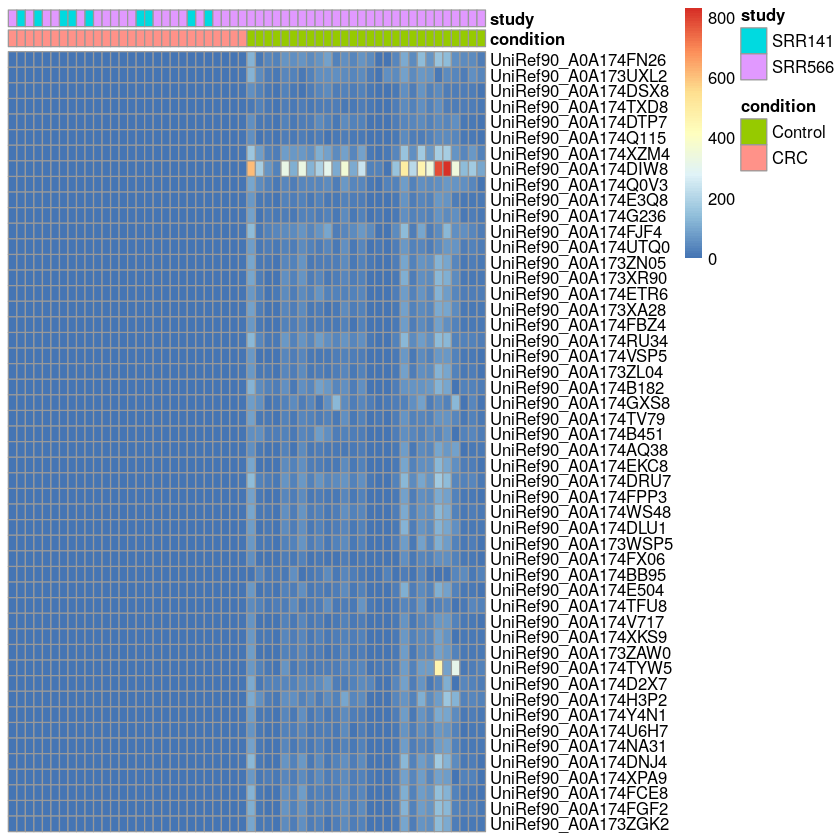

In [311]:
topgenes <- toptable[(toptable$qval < 0.0000000000000000000001),] #SIGNATURE 50
mat  <- genefamilies_unstrat_adj_EUA[topgenes$feature, c(CRC_EUA_samples, C_EUA_samples)]
pheatmap(mat, cluster_rows=FALSE, cluster_cols=FALSE, annotation_col = metadata_EUA[,c(3,4)], 
         show_colnames = FALSE)

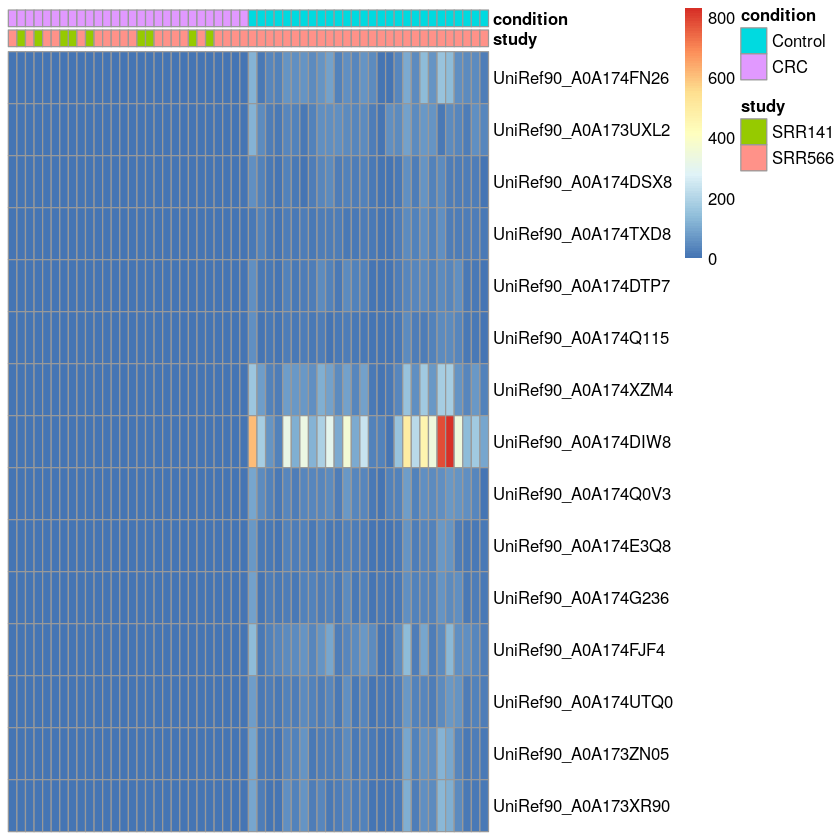

In [312]:
topgenes <- toptable[(toptable$qval < 0.00000000000000000000000001),] #SIGNATURE 15
mat  <- genefamilies_unstrat_adj_EUA[topgenes$feature, c(CRC_EUA_samples, C_EUA_samples)]
pheatmap(mat, cluster_rows=FALSE, cluster_cols=FALSE, show_colnames = FALSE,
         annotation_col = metadata[,c(4,3)])

In [382]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.000001,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.0000000000000000000001,]
nrow(topgenes_EUA)

intersect(topgenes_EUA$feature, topgenes_Xina$feature)

[1] 54

[1] 50

character(0)

In [385]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.00001,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.0000000000000000001,]
nrow(topgenes_EUA)

intersect(topgenes_EUA$feature, topgenes_Xina$feature)

[1] 217

[1] 237

character(0)

In [392]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.0001,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.0000000000001,]
nrow(topgenes_EUA)

intersect(topgenes_EUA$feature, topgenes_Xina$feature)

[1] 1369

[1] 1361

character(0)

In [463]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.001,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.000001,]
nrow(topgenes_EUA)

intersect(topgenes_EUA$feature, topgenes_Xina$feature)

[1] 4763

[1] 4842

[1] "UniRef90_A0A174E8J1" "UniRef90_A0A176UAW6" "UniRef90_A0A174CV30"
 [4] "UniRef90_A0A1C5XW61" "UniRef90_A0A173WZP6" "UniRef90_A0A174L206"
 [7] "UniRef90_A0A174NG87" "UniRef90_A0A174M525" "UniRef90_A0A174YIF7"
[10] "UniRef90_A0A174MDE8" "UniRef90_A0A0E9FRS3" "UniRef90_A0A173WWY2"
[13] "UniRef90_A0A174LGV6" "UniRef90_A0A174XUK7" "UniRef90_A0A1C6K3H6"
[16] "UniRef90_A0A174RDH8"

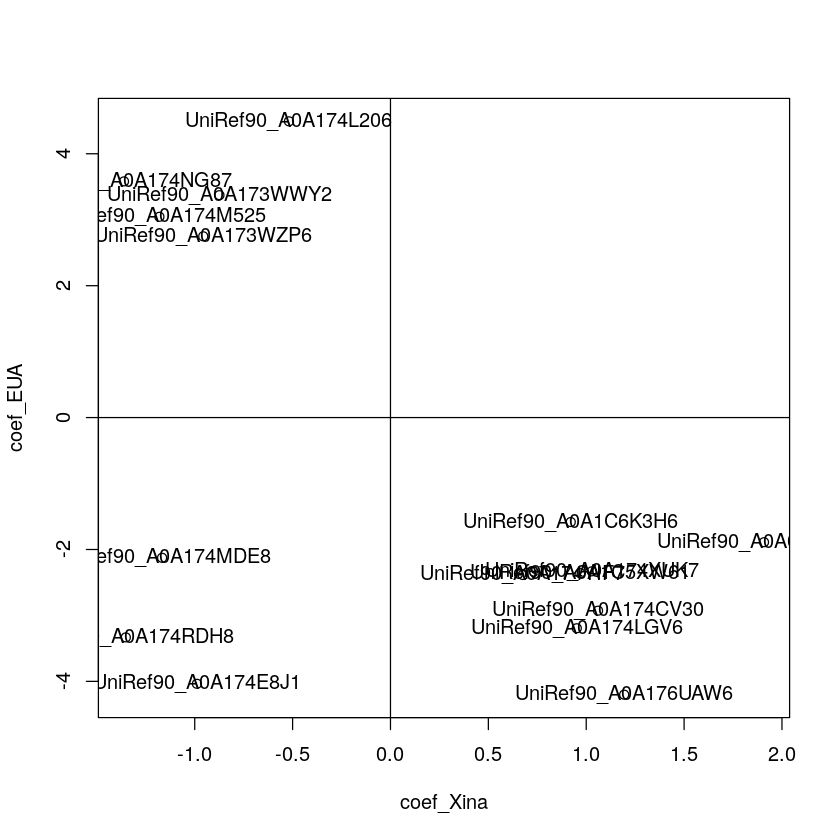

In [464]:
coef_Xina = numeric(0)
coef_EUA = numeric(0)
for (i in intersect(topgenes_Xina$feature, topgenes_EUA$feature)) {
    coef_Xina <- append(coef_Xina, topgenes_Xina$coef[topgenes_Xina$feature==i])
    coef_EUA <- append(coef_EUA, topgenes_EUA$coef[topgenes_EUA$feature==i])
}
plot(coef_Xina, coef_EUA,)
text(coef_Xina, coef_EUA, labels=intersect(topgenes_Xina$feature, topgenes_EUA$feature),
     cex=1, font=1)
abline(h=0,v=0)

In [465]:
sum(coef_EUA<0 & coef_Xina<0)

[1] 3

In [469]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.005,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.0001,]
nrow(topgenes_EUA)

[1] 8923

[1] 8625

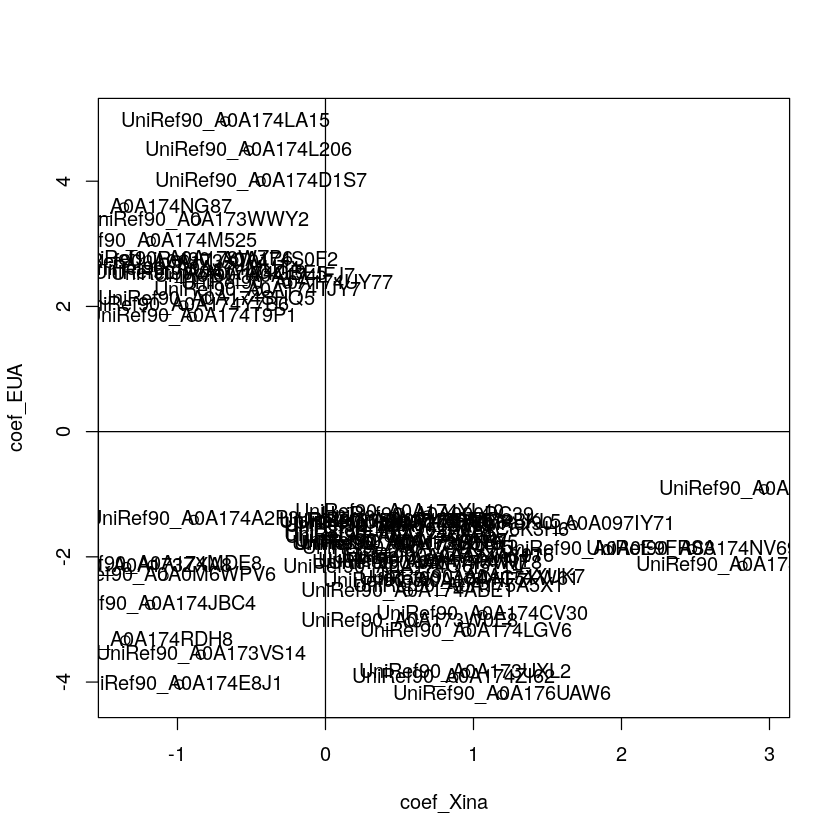

In [470]:
coef_Xina = numeric(0)
coef_EUA = numeric(0)
for (i in intersect(topgenes_Xina$feature, topgenes_EUA$feature)) {
    coef_Xina <- append(coef_Xina, topgenes_Xina$coef[topgenes_Xina$feature==i])
    coef_EUA <- append(coef_EUA, topgenes_EUA$coef[topgenes_EUA$feature==i])
}
plot(coef_Xina, coef_EUA,)
text(coef_Xina, coef_EUA, labels=intersect(topgenes_Xina$feature, topgenes_EUA$feature),
     cex=1, font=1)
abline(h=0,v=0)

In [471]:
sum(coef_EUA<0 & coef_Xina<0)

[1] 8

In [484]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.01,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.0005,]
nrow(topgenes_EUA)

[1] 11125

[1] 10791

In [485]:
coef_Xina = numeric(0)
coef_EUA = numeric(0)
for (i in intersect(topgenes_Xina$feature, topgenes_EUA$feature)) {
    coef_Xina <- append(coef_Xina, topgenes_Xina$coef[topgenes_Xina$feature==i])
    coef_EUA <- append(coef_EUA, topgenes_EUA$coef[topgenes_EUA$feature==i])
}
sum(coef_EUA<0 & coef_Xina<0)

[1] 9

In [486]:
sum(coef_EUA>0 & coef_Xina>0)

[1] 0

In [487]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.01,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.01,]
nrow(topgenes_EUA)

[1] 11125

[1] 14985

In [488]:
coef_Xina = numeric(0)
coef_EUA = numeric(0)
for (i in intersect(topgenes_Xina$feature, topgenes_EUA$feature)) {
    coef_Xina <- append(coef_Xina, topgenes_Xina$coef[topgenes_Xina$feature==i])
    coef_EUA <- append(coef_EUA, topgenes_EUA$coef[topgenes_EUA$feature==i])
}

sum(coef_EUA<0 & coef_Xina<0)

[1] 20

In [489]:
sum(coef_EUA>0 & coef_Xina>0)

[1] 0

In [494]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.05,]
nrow(topgenes_Xina)

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.05,]
nrow(topgenes_EUA)

[1] 19273

[1] 15507

In [495]:
coef_Xina = numeric(0)
coef_EUA = numeric(0)
for (i in intersect(topgenes_Xina$feature, topgenes_EUA$feature)) {
    coef_Xina <- append(coef_Xina, topgenes_Xina$coef[topgenes_Xina$feature==i])
    coef_EUA <- append(coef_EUA, topgenes_EUA$coef[topgenes_EUA$feature==i])
}

sum(coef_EUA<0 & coef_Xina<0)

[1] 83

In [496]:
sum(coef_EUA>0 & coef_Xina>0)

[1] 0

In [533]:
toptable <- read.delim("maaslin2_genefamilies_Xina/significant_results.tsv")
topgenes_Xina <- toptable[toptable$qval < 0.01,]

toptable <- read.delim("maaslin2_genefamilies_EUA/significant_results.tsv")
topgenes_EUA <- toptable[toptable$qval < 0.01,]

candidates = intersect(topgenes_Xina$feature, topgenes_EUA$feature)

coef_Xina = numeric(0)
sd_Xina = numeric(0)
qval_Xina = numeric(0)
coef_EUA = numeric(0)
sd_EUA = numeric(0)
qval_EUA = numeric(0)
select = numeric(0)
ok = numeric(0)
c = 0
for (i in candidates) {
    c = c + 1
    coef_Xina <- append(coef_Xina, topgenes_Xina$coef[topgenes_Xina$feature==i])
    sd_Xina <- append(sd_Xina, topgenes_Xina$stderr[topgenes_Xina$feature==i])
    qval_Xina <- append(qval_Xina, topgenes_Xina$qval[topgenes_Xina$feature==i])
    coef_EUA <- append(coef_EUA, topgenes_EUA$coef[topgenes_EUA$feature==i])
    sd_EUA <- append(sd_EUA, topgenes_EUA$stderr[topgenes_EUA$feature==i])
    qval_EUA <- append(qval_EUA, topgenes_EUA$qval[topgenes_EUA$feature==i])
    if (coef_Xina[c] < 0 & coef_EUA[c] < 0) {
        ok <- append(ok, "ok")
    } else {
        ok <- append(ok, "ko")
    }   
}        

df <- data.frame(candidates, ok, coef_Xina, sd_Xina, coef_EUA, sd_EUA, qval_Xina, qval_EUA)
df <- df[df$ok=="ok",-2]

In [535]:
df[order(df$coef_Xina, df$coef_EUA),]

,candidates,coef_Xina,sd_Xina,coef_EUA,sd_EUA,qval_Xina,qval_EUA
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
101,UniRef90_A0A174RDH8,-1.3520370,0.2866326,-3.3329731,0.5582004,0.0001342474,7.301629e-07
157,UniRef90_A0A173ZXA8,-1.3465401,0.3062374,-2.1621243,0.4070798,0.0003194859,7.843108e-06
156,UniRef90_A0A173RQY0,-1.3397721,0.3045192,-1.8203356,0.4642720,0.0003167743,5.608761e-04
201,UniRef90_A0A173VHW5,-1.2088001,0.2881478,-1.4617421,0.4509139,0.0005960176,3.900171e-03
249,UniRef90_A0A174JBC4,-1.1852073,0.2890161,-2.7663050,0.5271440,0.0007826396,8.696556e-06
143,UniRef90_A0A174MDE8,-1.1667681,0.2593151,-2.1260568,0.3422280,0.0002459023,3.001320e-07
168,UniRef90_A0A173ZUR1,-1.1438757,0.2648320,-1.2770485,0.3434375,0.0004092526,1.014927e-03
96,UniRef90_A0A174ZHW0,-1.1168594,0.2356358,-1.5145046,0.5064304,0.0001270195,7.595070e-03
433,UniRef90_A0A133YAI6,-1.0962643,0.2791398,-1.3845974,0.3719326,0.0012355331,1.003515e-03


In [569]:
write.table(df, file = "topgenes_CRC.tsv", sep="\t", row.names=FALSE)

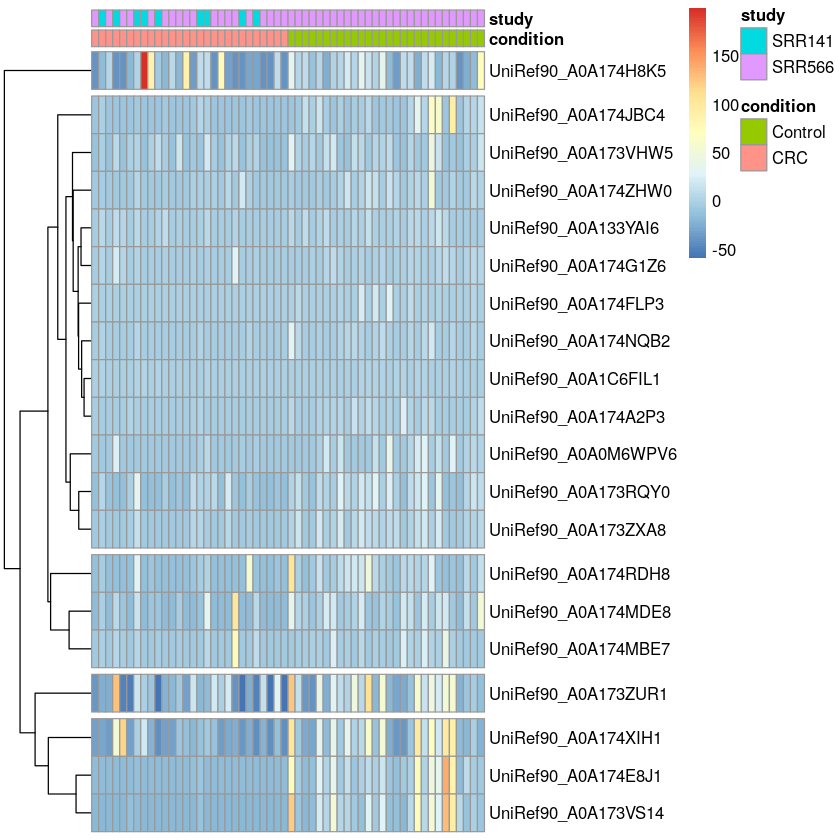

In [565]:
mat <- genefamilies_unstrat_adj_EUA[df$candidates, c(CRC_EUA_samples, C_EUA_samples)]
mat <- mat - rowMeans(mat)
pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata_EUA[,c(3,4)], 
         show_colnames = FALSE, cutree_rows=5)

In [567]:
pdf("heatmap_genefamilies_EUA.pdf")
mat <- genefamilies_unstrat_adj_EUA[df$candidates, c(CRC_EUA_samples, C_EUA_samples)]
mat <- mat - rowMeans(mat)
pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata_EUA[,c(3,4)], 
         show_colnames = FALSE, cutree_rows=5)
dev.off()

pdf 
  3

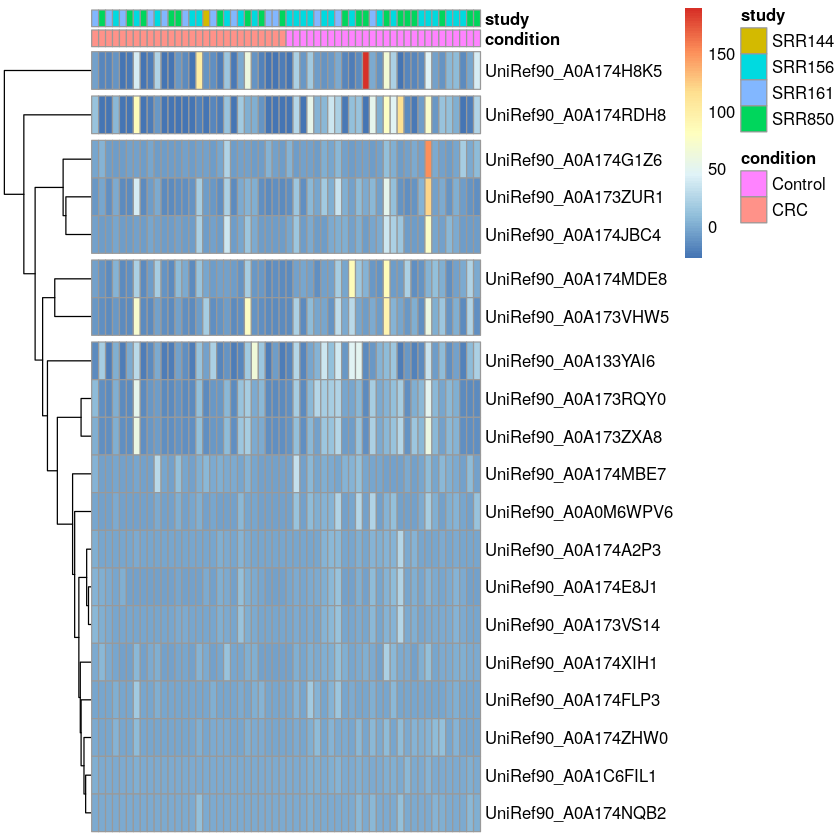

In [566]:
mat <- genefamilies_unstrat_adj_Xina[df$candidates, c(CRC_Xina_samples, C_Xina_samples)]
mat <- mat - rowMeans(mat)
pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata_Xina[,c(3,4)], 
         show_colnames = FALSE, cutree_rows=5)

In [568]:
pdf("heatmap_genefamilies_Xina.pdf")
mat <- genefamilies_unstrat_adj_Xina[df$candidates, c(CRC_Xina_samples, C_Xina_samples)]
mat <- mat - rowMeans(mat)
pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata_Xina[,c(3,4)], 
         show_colnames = FALSE, cutree_rows=5)
dev.off()

pdf 
  3

## DM2

In [9]:
genefamilies_dm2 <- read.delim("merged_cpm_genefamilies_dm2.tsv")

In [10]:
#Tots els valors han de ser enters                                          
genefamilies_dm2[1:nrow(genefamilies_dm2),2:length(genefamilies_dm2)] <- as.data.frame(lapply(genefamilies_dm2[1:nrow(genefamilies_dm2),
                                                                       2:length(genefamilies_dm2)], as.integer))
#Modifiquem nom columnes
tmp <- strsplit(readLines("merged_cpm_genefamilies_dm2.tsv", n=1), "\t")[[1]]
nms <- tmp[2:length(tmp)]
names(genefamilies_dm2)[2:length(genefamilies_dm2)] <- gsub("_Abundance-RPKs", "", nms)
                                          
#Modifiquem nom files
row.names(genefamilies_dm2) <- genefamilies_dm2[1:nrow(genefamilies_dm2),1]
genefamilies_dm2 <- genefamilies_dm2[,2:length(genefamilies_dm2)]

#Eliminem fila UNMAPPED
genefamilies_dm2 <- genefamilies_dm2[2:nrow(genefamilies_dm2), 1:length(genefamilies_dm2)]

#Eliminem files amb 0 per totes les mostres
genefamilies_dm2 <- genefamilies_dm2[rowSums(genefamilies_dm2 > 0)>0,1:length(genefamilies_dm2)]

In [11]:
metadata <- read.csv("metadades_DM2.csv")
# convertim condition a factor
metadata$condition <- factor(metadata$condition, levels=c("Control", "DM2"))
# reordenem per alinear mostres amb les columnes del arxiu de counts
metadata$sample2 <- metadata$sample
metadata <- left_join(data.frame(sample2 = colnames(genefamilies_dm2)), metadata)
#canviem nom de files
rownames(metadata) <- metadata$sample
#eliminem columnes no necessàries
metadata <- metadata[1:nrow(metadata),3:length(metadata)]

Joining, by = "sample2"


In [6]:
#Transformem counts a taula no estratificada
unstrat_table <- function(counts) {
    temp = counts[!grepl("\\|", rownames(counts)),]
    return(temp)
}
genefamilies_dm2_unstrat <- unstrat_table(genefamilies_dm2)

In [579]:
fit_adjust_batch <- MMUPHin::adjust_batch(feature_abd=genefamilies_dm2_unstrat, batch="study",
                                covariates = c("condition"),
                                data = metadata,
                                control = list(verbose=TRUE))
genefamilies_dm2_unstrat_adj <- fit_adjust_batch$feature_abd_adj
write.table(genefamilies_dm2_unstrat_adj, file = "genefamilies_adj_dm2.tsv", sep="\t", row.names=FALSE)

feature_abd is counts

Warning message in check_batch(df_batch[[batch]], min_n_batch = 2):
“Batch variable is not a factor as provided and will be converted to one.”
Found 3 batches

Adjusting for 1 covariate(s) or covariate(s) level(s)

Pseudo count is not specified and set to half of minimal non-zero value: 5e-01

Adjusting for (after filtering) 463153 features

Standardizing data across features

Estimating batch difference parameters and EB priors

Performing shrinkage adjustments on batch difference parameters

Performing batch corrections



ERROR: Error in is.data.frame(x): object 'genefamilies_dm2_unstrat_ad' not found


In [580]:
write.table(genefamilies_dm2_unstrat_adj, file = "genefamilies_adj_dm2.tsv", sep="\t", row.names=FALSE)

In [7]:
genefamilies_dm2_unstrat_adj <- read.delim("genefamilies_adj_dm2.tsv")
row.names(genefamilies_dm2_unstrat_adj) <- row.names(genefamilies_dm2_unstrat)

In [13]:
maaslin <- Maaslin2(input_data = genefamilies_dm2_unstrat_adj ,
                    input_metadata = metadata,
                    output = "maaslin2_genefamilies_dm2",
                    fixed_effects = c("condition"),
                    random_effects = c("study"),
                    normalization = "NONE",
                    min_abundance = 0.0001,
                    min_prevalence = 0.1,
                    plot_scatter = FALSE,
                     cores = 6)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[1] "There is not enough metadata in the associations to create a heatmap plot. Please review the associations in text output file."


In [14]:
toptable <- read.delim("maaslin2_genefamilies_dm2/significant_results.tsv")

In [17]:
#0.01
nrow(toptable[toptable$qval < 0.01,])
#0.00001
nrow(toptable[toptable$qval < 0.00001,])
#0.000001
nrow(toptable[toptable$qval < 0.000001,])
#0.0000001
nrow(toptable[toptable$qval < 0.0000001,])
#0.00000001
nrow(toptable[toptable$qval < 0.00000001,])
#0.000000001
nrow(toptable[toptable$qval < 0.000000001,])
#0.0000000001
nrow(toptable[toptable$qval < 0.0000000001,])
#0.00000000001
nrow(toptable[toptable$qval < 0.00000000001,])
#0.000000000001
nrow(toptable[toptable$qval < 0.000000000001,])
#0.0000000000001
nrow(toptable[toptable$qval < 0.0000000000001,])

[1] 64900

[1] 12266

[1] 8065

[1] 4633

[1] 2153

[1] 705

[1] 196

[1] 45

[1] 21

[1] 5

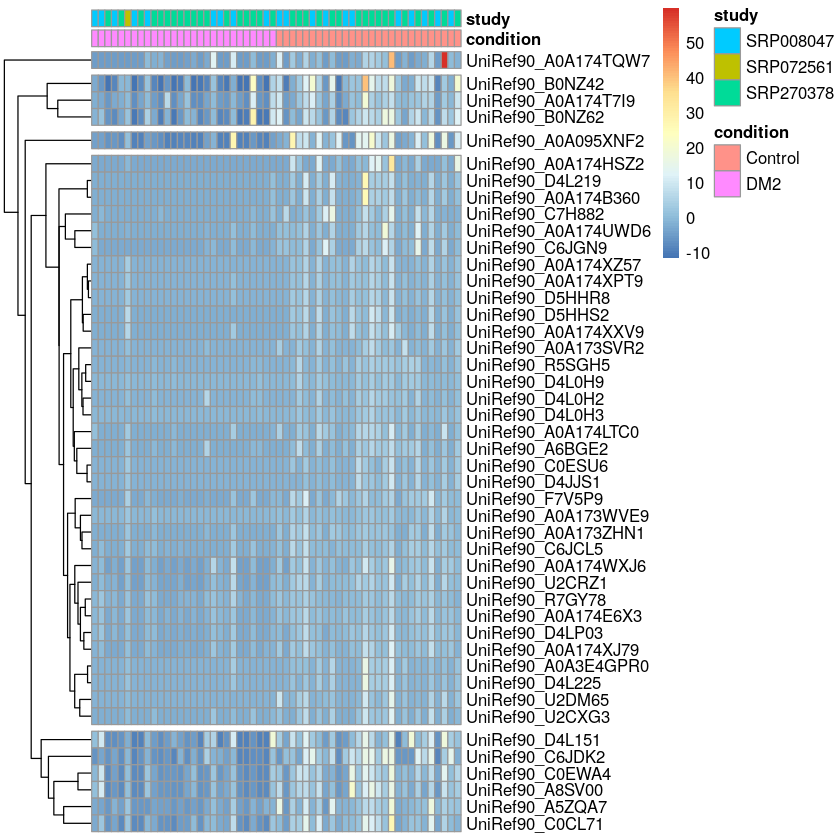

In [38]:
set.seed(42)
DM2_samples <- sample(row.names(metadata)[metadata$condition=="DM2"],28)
C_samples <- sample(row.names(metadata)[metadata$condition=="Control"],28)

topgenes <- toptable[toptable$qval < 0.00000000001,]
mat <- genefamilies_dm2_unstrat_adj[topgenes$feature,c(DM2_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata, 
         show_colnames = FALSE, cutree_rows=5)

In [40]:
write.table(topgenes, file = "topgenes_DM2.tsv", sep="\t", row.names=FALSE)

In [34]:
pdf("heatmap_genefamilies_DM2.pdf")
topgenes <- toptable[toptable$qval < 0.00000000001,]
mat <- genefamilies_dm2_unstrat_adj[topgenes$feature,c(DM2_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata, 
         show_colnames = FALSE, cutree_rows=5)
dev.off()

pdf 
  3

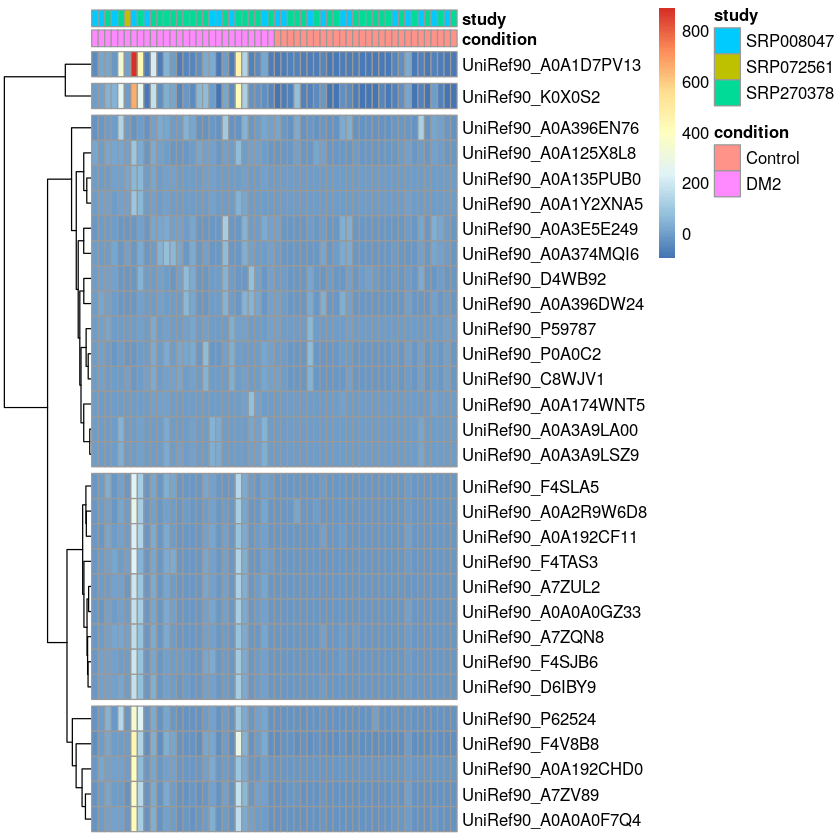

In [33]:
topgenes <- toptable[toptable$qval < 0.00000001,]
topgenes_pos <- topgenes[topgenes$coef>0,]
mat <- genefamilies_dm2_unstrat_adj[topgenes_pos$feature,c(DM2_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata, 
         show_colnames = FALSE, cutree_rows=5)

In [35]:
pdf("heatmap_genefamilies_DM2_supra.pdf")
topgenes <- toptable[toptable$qval < 0.00000001,]
topgenes_pos <- topgenes[topgenes$coef>0,]
mat <- genefamilies_dm2_unstrat_adj[topgenes_pos$feature,c(DM2_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata, 
         show_colnames = FALSE, cutree_rows=5)
dev.off()

pdf 
  3

In [41]:
write.table(topgenes_pos, file = "topgenes_pos_DM2.tsv", sep="\t", row.names=FALSE)

## PD

In [1]:
genefamilies_pd <- read.delim("merged_cpm_genefamilies_pd.tsv")

In [2]:
#Tots els valors han de ser enters                                          
genefamilies_pd[1:nrow(genefamilies_pd),2:length(genefamilies_pd)] <- as.data.frame(lapply(genefamilies_pd[1:nrow(genefamilies_pd),
                                                                       2:length(genefamilies_pd)], as.integer))
#Modifiquem nom columnes
tmp <- strsplit(readLines("merged_cpm_genefamilies_pd.tsv", n=1), "\t")[[1]]
nms <- tmp[2:length(tmp)]
names(genefamilies_pd)[2:length(genefamilies_pd)] <- gsub("_Abundance-RPKs", "", nms)
                                          
#Modifiquem nom files
row.names(genefamilies_pd) <- genefamilies_pd[1:nrow(genefamilies_pd),1]
genefamilies_pd <- genefamilies_pd[,2:length(genefamilies_pd)]

#Eliminem fila UNMAPPED
genefamilies_pd <- genefamilies_pd[2:nrow(genefamilies_pd), 1:length(genefamilies_pd)]

#Eliminem files amb 0 per totes les mostres
genefamilies_pd <- genefamilies_pd[rowSums(genefamilies_pd > 0)>0,1:length(genefamilies_pd)]

In [63]:
metadata <- read.csv("metadades_PD.csv", fileEncoding="iso-8859-1")
# convertim condition a factor
metadata$condition <- factor(metadata$condition, levels=c("Control", "PD"))
# reordenem per alinear mostres amb les columnes del arxiu de counts
metadata$sample2 <- metadata$sample
metadata <- left_join(data.frame(sample2 = colnames(genefamilies_pd)), metadata)
#canviem nom de files
rownames(metadata) <- metadata$sample
#eliminem columnes no necessàries
metadata <- metadata[1:nrow(metadata),3:length(metadata)]

Joining, by = "sample2"


In [7]:
#Transformem counts a taula no estratificada
unstrat_table <- function(counts) {
    temp = counts[!grepl("\\|", rownames(counts)),]
    return(temp)
}
genefamilies_pd_unstrat <- unstrat_table(genefamilies_pd)

In [46]:
fit_adjust_batch <- MMUPHin::adjust_batch(feature_abd=genefamilies_pd_unstrat, batch="study",
                                covariates = c("condition"),
                                data = metadata,
                                control = list(verbose=TRUE))
genefamilies_pd_unstrat_adj <- fit_adjust_batch$feature_abd_adj
write.table(genefamilies_pd_unstrat_adj, file = "genefamilies_adj_pd.tsv", sep="\t", row.names=FALSE)

feature_abd is counts

Warning message in check_batch(df_batch[[batch]], min_n_batch = 2):
“Batch variable is not a factor as provided and will be converted to one.”
Found 2 batches

Adjusting for 1 covariate(s) or covariate(s) level(s)

Pseudo count is not specified and set to half of minimal non-zero value: 5e-01

Adjusting for (after filtering) 348788 features

Standardizing data across features

Estimating batch difference parameters and EB priors

Performing shrinkage adjustments on batch difference parameters

Performing batch corrections



In [47]:
write.table(genefamilies_pd_unstrat_adj, file = "genefamilies_adj_pd.tsv", sep="\t", row.names=FALSE)

In [8]:
genefamilies_pd_unstrat_adj <- read.delim("genefamilies_adj_pd.tsv")
row.names(genefamilies_pd_unstrat_adj) <- row.names(genefamilies_pd_unstrat)

In [9]:
maaslin <- Maaslin2(input_data = genefamilies_pd_unstrat_adj ,
                    input_metadata = metadata,
                    output = "maaslin2_genefamilies_pd",
                    fixed_effects = c("condition"),
                    random_effects = c("study"),
                    normalization = "NONE",
                    min_abundance = 0.0001,
                    min_prevalence = 0.1,
                    plot_scatter = FALSE,
                     cores = 6)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


[1] "There is not enough metadata in the associations to create a heatmap plot. Please review the associations in text output file."


In [10]:
toptable <- read.delim("maaslin2_genefamilies_pd/significant_results.tsv")

In [27]:
#0.01
nrow(toptable[toptable$qval < 0.01,])
#0.009
nrow(toptable[toptable$qval < 0.009,])
#p=0.00001
nrow(toptable[toptable$qval < 0.01 & toptable$pval < 0.00001,])
#p=0.000005
nrow(toptable[toptable$qval < 0.01 & toptable$pval < 0.000005,])
#p=0.000003
nrow(toptable[toptable$qval < 0.01 & toptable$pval < 0.000003,])
#p=0.000001
nrow(toptable[toptable$qval < 0.01 & toptable$pval < 0.000001,])

[1] 593

[1] 0

[1] 215

[1] 80

[1] 37

[1] 8

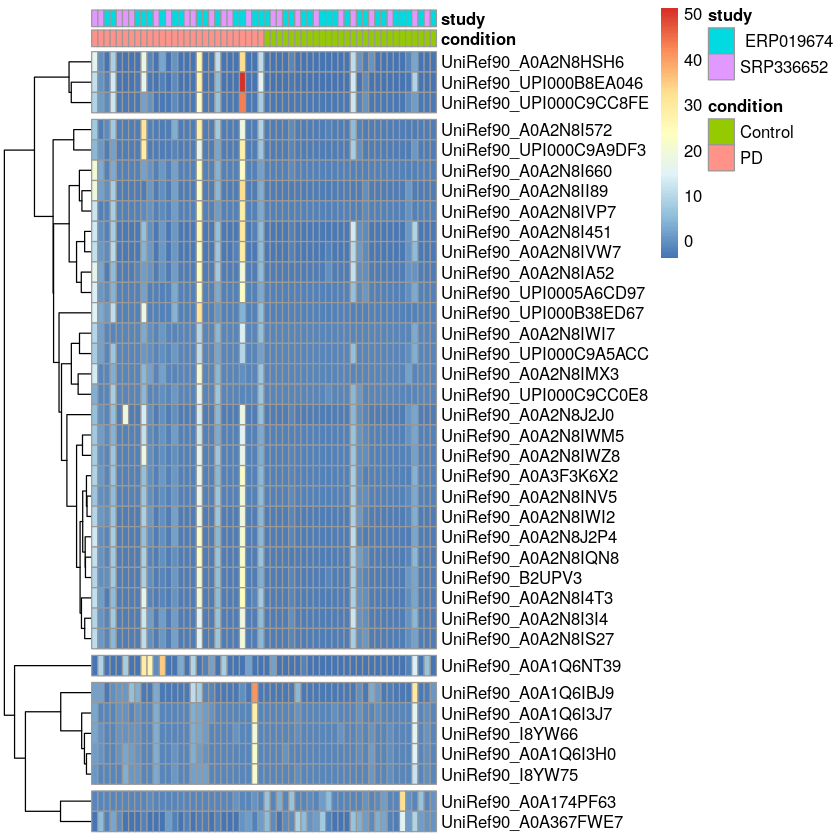

In [70]:
set.seed(42)
PD_samples <- sample(row.names(metadata)[metadata$condition=="PD"],28)
C_samples <- sample(row.names(metadata)[metadata$condition=="Control"],28)

topgenes <- toptable[(toptable$qval < 0.01) & (toptable$pval < 0.000003),]
mat <- genefamilies_pd_unstrat_adj[topgenes$feature,c(PD_samples, C_samples)]
mat <- mat - rowMeans(mat)

pheatmap(mat, cluster_rows=TRUE, cluster_cols=FALSE, annotation_col = metadata, 
         show_colnames = FALSE, cutree_rows=5)

In [67]:
write.table(topgenes, file = "topgenes_PD.tsv", sep="\t", row.names=FALSE)

In [68]:
sum(topgenes$coef>0)
sum(topgenes$coef<0)

[1] 35

[1] 2